In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.

In [2]:
path = 'C://Users/bapat/OneDrive/Desktop/CSULB_Course/03 - Fall 23/PR/02 - Assignments/Assignment05/lfw/lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

In [4]:
#Create folder to store the intermediate output images during training
if not os.path.exists('./generated'):
    os.mkdir('./generated')

#Function to reshape the tensor into (batch_size, 1, 250, 250)
def to_img(x):
    x = x.view(x.size(0), 1, 250, 250)
    return x

torch.Size([250, 250, 3])


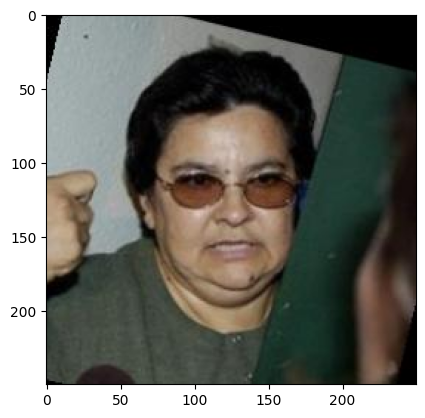

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

Image dimensions: torch.Size([3, 250, 250])


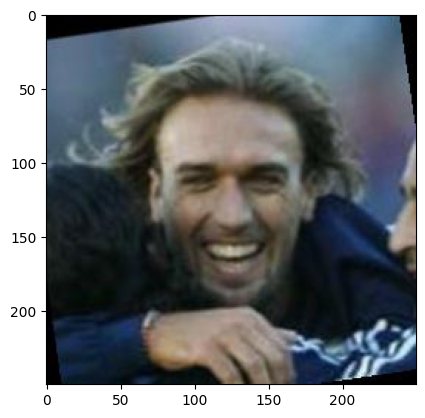

In [5]:
for x, y in dataloader:
    # Select the first image from the batch
    sample_image = x[0]
    # Print dimensions
    print("Image dimensions:", sample_image.shape)
    #Change dimensions as matplotlib accepts the form of (height, width, channels)
    sample_image = sample_image.permute(1, 2, 0)
    # Plot the image
    plt.imshow(sample_image)
    plt.show()
    break

In [7]:
torch.min(sample_image), torch.max(sample_image)

(tensor(0.), tensor(1.))

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [10]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = self._build_encoder()

        self.decoder = self._build_decoder()
        
    #Encoder
    def _build_encoder(self):
        return nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.BatchNorm2d(64),
                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.BatchNorm2d(128),
                nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.BatchNorm2d(256),
            )
    
    #Decoder
    def _build_decoder(self):
          return nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=10, stride=4, padding=1, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=6, stride=4, padding=4, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=6, stride=4, padding=2),
            nn.Sigmoid()  
          )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [15]:
#Create instance of the class
model = AE()

In [40]:
#Select an image to pass it to the model
sample = x[3,:,:,:]

In [41]:
#Print the shape of the image
sample.shape

torch.Size([3, 250, 250])

In [42]:
#Pass the image to the model
input_image = sample.unsqueeze(0)
encoded_image = model.encoder(input_image)
decoded_image = model.decoder(encoded_image)

In [46]:
#Print the shapes of the input, encoded and decoded image
print("Input image shape: ", input_image.shape)
print("Encoded image shape: ", encoded_image.shape)
print("Decoded image shape: ", decoded_image.shape)

Input image shape:  torch.Size([1, 3, 250, 250])
Encoded image shape:  torch.Size([1, 256, 3, 3])
Decoded image shape:  torch.Size([1, 3, 250, 250])


-  Here we can see that the shape of the input image and the shape of the decoded image is the same. 
-  This would help in preserving the information of the original image. 
-  Also matching the size between the model input and output would help in evaluating the loss. 
-  The size of the encoded image tells us that the image information is compressed to that size.

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [79]:
#Print the total number of parameters in the model
total_parameters = sum(m.numel() for m in model.parameters())
print("Total Parameters: ", total_parameters)

Total Parameters:  4238595


In [9]:
#Defining the number of epochs and learning rate
num_epochs = 100
learning_rate = 1e-3

In [10]:
#Defining the loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

I would use the Mean Squared Error as the loss function. For autoencoders, we require that the input and actual output is minimized and for that reason I selected MSE. MSE measures the average squared distance between corresponding elements of input and output.

Also for Optimizer, I would be using the Adam optimizer as it gives fast convergence in training.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [11]:
from torchvision.utils import save_image, make_grid

In [12]:
for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, y = data

        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)

        # ===================backward====================

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data

    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, total_loss))
   
    if epoch % 10 == 0:
        pic = to_img(output[0].cpu().data)
        save_image(pic, './generated/image_{}.png'.format(epoch))

epoch [1/100], loss:0.8733
epoch [2/100], loss:0.6126
epoch [3/100], loss:0.5070
epoch [4/100], loss:0.4445
epoch [5/100], loss:0.3871
epoch [6/100], loss:0.3504
epoch [7/100], loss:0.3205
epoch [8/100], loss:0.2994
epoch [9/100], loss:0.2770
epoch [10/100], loss:0.2644
epoch [11/100], loss:0.2363
epoch [12/100], loss:0.2255
epoch [13/100], loss:0.2057
epoch [14/100], loss:0.1918
epoch [15/100], loss:0.1764
epoch [16/100], loss:0.1715
epoch [17/100], loss:0.1599
epoch [18/100], loss:0.1484
epoch [19/100], loss:0.1397
epoch [20/100], loss:0.1358
epoch [21/100], loss:0.1274
epoch [22/100], loss:0.1255
epoch [23/100], loss:0.1171
epoch [24/100], loss:0.1120
epoch [25/100], loss:0.1023
epoch [26/100], loss:0.0966
epoch [27/100], loss:0.0921
epoch [28/100], loss:0.0933
epoch [29/100], loss:0.0885
epoch [30/100], loss:0.0908
epoch [31/100], loss:0.0935
epoch [32/100], loss:0.0908
epoch [33/100], loss:0.0834
epoch [34/100], loss:0.0805
epoch [35/100], loss:0.0791
epoch [36/100], loss:0.0752
e

To troubleshoot when the loss was not decreasing:

-  For the previous models that I tried, the loss was getting stuck at the same rate of 0.09. 

-  To try and rectify it I reduced the learning rate from 0.01 to 0.001. 

-  I also increased the number of layers in my model and made it more complex so that it learns better. To make it more complex I added another layer of Convolution layer and Maxpooling layer. After that I also adjusted the dimensions in encoder and decoder so that the the output of decoder matches the input size of (3,250,250)

-  The model training also stores the intermediate output images after every 10 epochs in the generated folder. The series of images gives us an idea of how the model is learning features during the training process.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

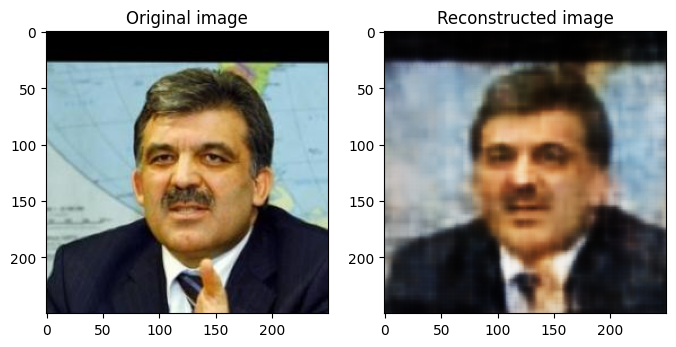

In [14]:
for images,_ in dataloader:
    #Take a sample image from the dataset
    original_image = images[1]

    with torch.no_grad():
        output = model(original_image.unsqueeze(0))
        
    original_image_np = original_image.permute(1,2,0).cpu().numpy()
    recon_image_np = output[-1].squeeze(0).permute(1,2,0).cpu().numpy()
    
    #Plot the images
    fig, axes = plt.subplots(1,2,figsize=(8,4))
    axes[0].imshow(original_image_np)
    axes[0].set_title("Original image")
  
    axes[1].imshow(recon_image_np)
    axes[1].set_title("Reconstructed image")
    plt.show()
    break

In [15]:
#Save the model
torch.save(model.state_dict(), "newmodel.pth")

In [71]:
#Load the model
model.load_state_dict(torch.load('newmodel.pth'))

<All keys matched successfully>

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

In [26]:
# Take a sample image from the dataloader
sample_batch = next(iter(dataloader))
sample_image = sample_batch[0][0].unsqueeze(0)  

# Add noise to the sample image
noise_factor = 0.1
noisy_image = sample_image + noise_factor * torch.randn_like(sample_image)

In [27]:
# Pass the noisy image through the model
with torch.no_grad():
    reconstructed_output = model(noisy_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


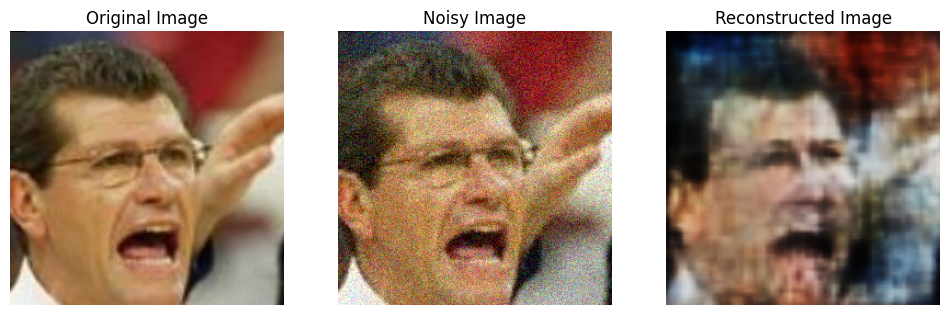

In [28]:
# Display the original, noisy, and reconstructed images
original_image = sample_image.squeeze(0).permute(1, 2, 0).numpy()
noisy_image = noisy_image.squeeze(0).permute(1, 2, 0).numpy()
reconstructed_image = reconstructed_output.squeeze(0).permute(1, 2, 0).numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Noisy Image")
plt.imshow(noisy_image)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.axis("off")

plt.show()

- Adding noise to the input image has made the reconstructed image even more distorted.
- The autoencoder has not removed all the noise present in the image.
- The reason for this is during training I haven't added any noise to the input dataset. If the model had been trained on some noisy data then the reconstructed image from the noisy image would have been cleaner and devoid of noise.
- But as this is not the case, the reconstructed image is giving me a noisy output as the model has not learned how to incorporate noisy data.